## Part 1 Inspecting and selecting working light curve

* [exoplanet.eu](http://exoplanet.eu/catalog/HAT-P-20_b/)
* [refined transit parameter and TTV](http://iopscience.iop.org/article/10.3847/1538-3881/153/1/28/meta;jsessionid=9BBDAE49F56E6A82A352486336DDA46E.c3.iopscience.cld.iop.org)

* [raw data](https://drive.google.com/drive/folders/0B63CzRbwz8jFa1djQmlaMnZtblE?usp=sharing)
* obsdate: January 24, 2017
* tools to remove outliers and create light curves for "systematic correction using multiband information"

* lc_msct_hatp12_170124.tar.gz contains a set of light curves created with different combinations of comparison stars without outliers removed.
* Each line in the files lists several flux (or magnitude) values calculated with different aperture radii.

* fov_msct_HAT-P-20_170214.png shows an r-band image used for a reference, indicating the stellar IDs of the target star (red) and comparison stars (yellow).
* The inner most circle for each star represents the aperture having the maximum radius applied here (36 pixels).
* The blue annuli indicate the regions where the sky backgrounds are estimated.

* Note that during this observation, clouds passed at some points which produced many outliers in the light curves.
* In addition, the target star has a companion star at ~7 arcsec away which heavily contaminates the target star due to **defocusing**.
* Because of this, photometries are done with large aperture radii so that both HAT-P-20 and the companion star are included in the apertures.
* These facts would make future publication of these data unrealistic, but the data would still be useful for some exercises, including preparation of light-curve modeling pipelines for MuSCAT2.
* The outliers can be removed by yourself using the tools in tools4muscatlc.tar.

* lc_msct_hatp12_170124_example.tar.gz contains some example light curves with outliers removed by the tools, and example light curves for systematic correction using multiband information.

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'afapphot'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '/home/'+getpass.getuser()+'/data/transit/hatp20_data/lc_msct_hatp12_170124_example'

file_list=glob.glob(data_dir+'/*.dat')
file_list.sort()
len(file_list)

15

In [5]:
file_list[0]

'/home/jp/data/transit/hatp20_data/lc_msct_hatp12_170124_example/lcf_msct_g_hatp12_170124_t1_c23_r28-36.bjd.cut.dat'

## import lc

In [6]:
band = 'g'
target_name = 'hatp12'
date = '170124'
target_star_id = '1'
comparison_star_ids = '23' 
aper_rad_range = '28-36'

data={}
data2={} #outliers remoed
bands='g,r,z'.split(',')
for b in bands:
    fname='lcf_msct_'+b+'_'+target_name+'_'+date+'_t'+target_star_id+\
            '_c'+comparison_star_ids+'_r'+aper_rad_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    df = df.set_index('BJD(TDB)-2450000')
    try:
        df=df.drop('Unnamed: 20',1)
    except:
        pass
    #df.head()
    data[b]=df

## g-band

In [7]:
df_g=data['g']
df_g.columns='airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,frame,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0),dummy,dummy'.split(',')
df_g = df_g.drop(['frame','dummy'],1)
df_g.head()

,airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0)
BJD(TDB)-2450000,,,,,,,,,,,,,,,,
2.0020,7777.909506,2405.4,-0.935,0.031,20.27,25088.1,1.009561,0.001278,1.009870,0.001295,1.010672,0.001314,1.011262,0.001333,1.011232,0.001353
1.9890,7777.910247,2333.3,-1.152,-0.389,18.27,27535.2,1.010649,0.001263,1.010884,0.001279,1.011460,0.001297,1.011771,0.001316,1.012044,0.001336
1.9762,7777.910988,2286.7,-1.875,-0.652,20.20,24268.0,1.007241,0.001245,1.008239,0.001262,1.009237,0.001280,1.009581,0.001298,1.009450,0.001317
1.9633,7777.911740,2260.4,-0.495,0.616,20.32,23723.2,1.008321,0.001237,1.009635,0.001254,1.010349,0.001272,1.010918,0.001290,1.011116,0.001309
1.9509,7777.912480,2236.0,-1.299,-0.820,21.36,22032.3,1.006226,0.001224,1.007489,0.001241,1.009005,0.001259,1.010029,0.001278,1.010359,0.001297


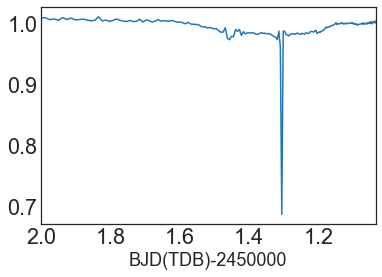

In [8]:
df_g['flux(r=28.0)'].plot()

In [9]:
from astropy.stats import sigma_clip

xc=sigma_clip(df_g['dx(pix)'], sigma_upper=3,sigma_lower=10)
yc=sigma_clip(df_g['dy(pix)'], sigma_upper=3,sigma_lower=10)
fc=sigma_clip(df_g['flux(r=28.0)'], sigma_upper=3,sigma_lower=10)
sum(xc.mask)+sum(yc.mask)+sum(fc.mask)

4

In [21]:
outliers_g=(xc.mask | yc.mask | fc.mask)
df_g=df_g[~outliers_g]

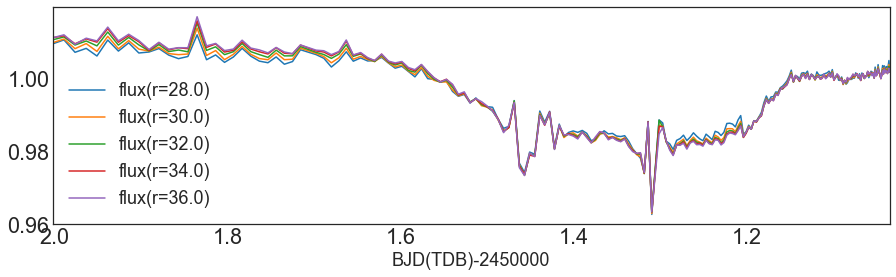

In [22]:
fig,ax=pl.subplots(1,1,figsize=(15,4))

cols=['flux(r={0:.1f})'.format(i) for i in np.arange(28,37,2)]
df_g[cols].plot(ax=ax)

## Auxiliary parameters

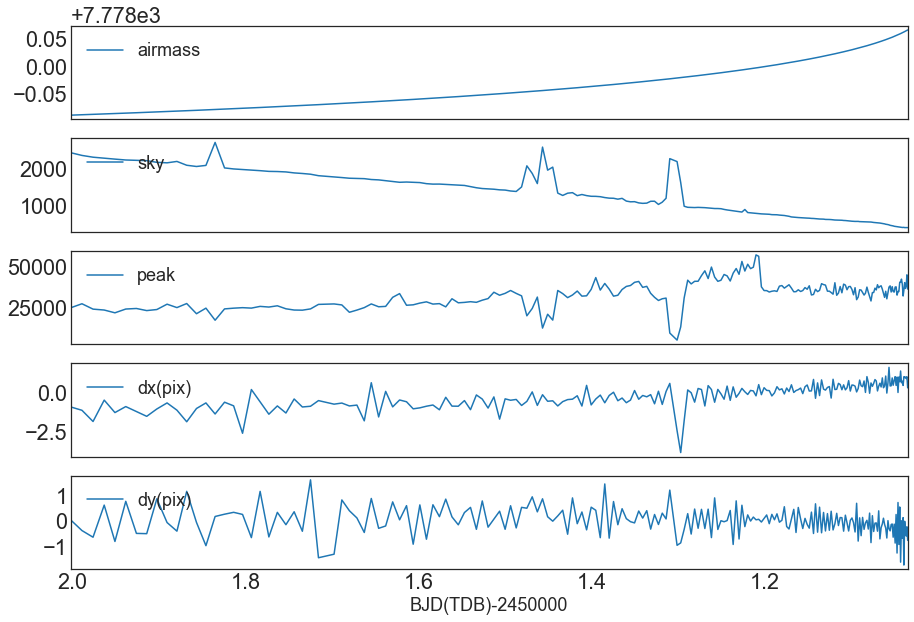

In [23]:
fig,ax=pl.subplots(5,1,figsize=(15,10), sharex=True)

aux_cols='airmass,sky,peak,dx(pix),dy(pix)'.split(',')

for n,c in enumerate(aux_cols):
    df_g[c].plot(ax=ax[n],label=c)
    ax[n].legend(loc='upper left')
    #ax[n].set_xticks([])
    #ax[n].set_xlabel('')
#fig.tight_layout()

## r-band

In [24]:
df_r=data['r']
df_r.columns='airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,frame,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0),dummy,dummy'.split(',')
df_r = df_r.drop(['frame','dummy'],1)
df_r.head()

,airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0)
BJD(TDB)-2450000,,,,,,,,,,,,,,,,
2.0057,7777.909298,894.6,-0.054,-0.136,18.45,23569.4,1.002499,0.001939,1.002356,0.001949,1.002447,0.001961,1.002792,0.001973,1.003174,0.001987
2.0006,7777.909587,893.9,1.236,1.254,18.61,20315.0,1.001523,0.001931,1.001908,0.001942,1.002320,0.001954,1.002717,0.001967,1.003270,0.001981
1.9955,7777.909877,884.9,0.085,-0.773,18.67,21436.0,1.004452,0.001928,1.005229,0.001940,1.005562,0.001952,1.006071,0.001965,1.006395,0.001978
1.9906,7777.910154,867.8,0.250,-0.267,17.58,23147.4,1.002752,0.001916,1.002992,0.001927,1.003516,0.001939,1.003817,0.001951,1.004091,0.001964
1.9856,7777.910444,855.6,0.903,0.744,15.87,28702.4,1.004993,0.001911,1.004565,0.001921,1.004593,0.001931,1.004649,0.001943,1.004639,0.001955


In [25]:
from astropy.stats import sigma_clip

xc=sigma_clip(df_r['dx(pix)'], sigma_upper=3,sigma_lower=10)
yc=sigma_clip(df_r['dy(pix)'], sigma_upper=3,sigma_lower=10)
fc=sigma_clip(df_r['flux(r=28.0)'], sigma_upper=3,sigma_lower=10)
sum(xc.mask)+sum(yc.mask)+sum(fc.mask)

18

In [26]:
outliers_r=(xc.mask | yc.mask | fc.mask)
df_r=df_r[~outliers_r]

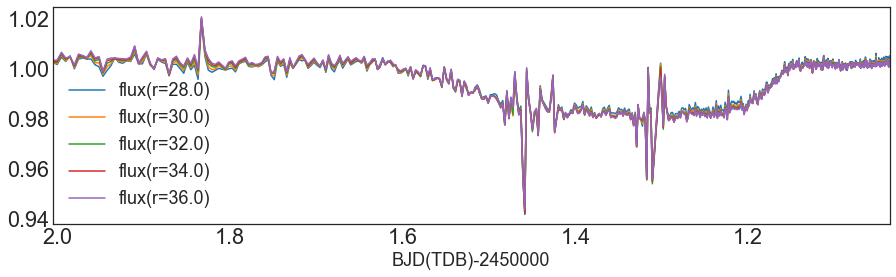

In [27]:
fig,ax=pl.subplots(1,1,figsize=(15,4))

cols=['flux(r={0:.1f})'.format(i) for i in np.arange(28,37,2)]
df_r[cols].plot(ax=ax)

## Auxiliary parameters

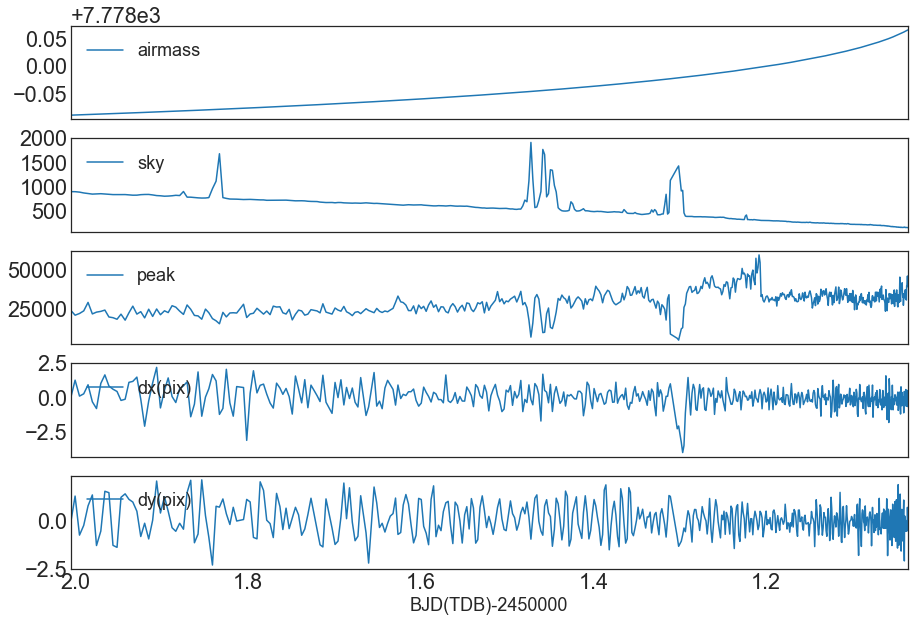

In [28]:
fig,ax=pl.subplots(5,1,figsize=(15,10), sharex=True)

aux_cols='airmass,sky,peak,dx(pix),dy(pix)'.split(',')

for n,c in enumerate(aux_cols):
    df_r[c].plot(ax=ax[n],label=c)
    ax[n].legend(loc='upper left')
    #ax[n].set_xticks([])
    #ax[n].set_xlabel('')
#fig.tight_layout()

## z-band

In [29]:
df_z=data['z']
df_z.columns='airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,frame,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0),dummy,dummy'.split(',')
df_z = df_z.drop(['frame','dummy'],1)
df_z.head()

,airmass,sky,dx(pix),dy(pix),fwhm(pix),peak,flux(r=28.0),err(r=28.0),flux(r=30.0),err(r=30.0),flux(r=32.0),err(r=32.0),flux(r=34.0),err(r=34.0),flux(r=36.0),err(r=36.0)
BJD(TDB)-2450000,,,,,,,,,,,,,,,,
2.0022,7777.909495,418.0,1.593,1.054,19.09,21855.3,1.001836,0.001431,1.001867,0.001449,1.001874,0.001469,1.001793,0.001489,1.002008,0.001511
1.9912,7777.910120,408.9,1.257,0.148,17.83,23590.5,1.000978,0.001422,1.001183,0.001440,1.001367,0.001460,1.001650,0.001481,1.001536,0.001502
1.9802,7777.910756,404.3,0.634,1.202,18.51,22171.3,1.000442,0.001409,1.000786,0.001427,1.000795,0.001446,1.000672,0.001466,1.000750,0.001487
1.9694,7777.911381,406.7,2.002,0.604,18.87,21555.5,1.002301,0.001403,1.002498,0.001421,1.002398,0.001439,1.002318,0.001459,1.002709,0.001481
1.9588,7777.912006,404.0,1.591,0.304,20.83,17479.3,0.998699,0.001392,0.999842,0.001411,1.000560,0.001431,1.000665,0.001451,1.000950,0.001473


In [30]:
from astropy.stats import sigma_clip

xc=sigma_clip(df_z['dx(pix)'], sigma_upper=3,sigma_lower=10)
yc=sigma_clip(df_z['dy(pix)'], sigma_upper=3,sigma_lower=10)
fc=sigma_clip(df_z['flux(r=28.0)'], sigma_upper=3,sigma_lower=10)
sum(xc.mask)+sum(yc.mask)+sum(fc.mask)

11

In [31]:
outliers_z=(xc.mask | yc.mask | fc.mask)
df_z=df_z[~outliers_z]

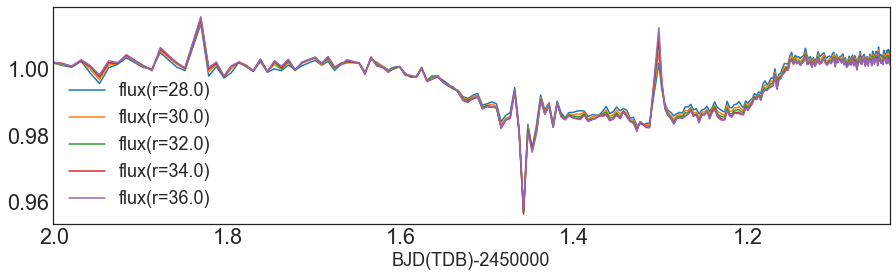

In [32]:
fig,ax=pl.subplots(1,1,figsize=(15,4))

cols=['flux(r={0:.1f})'.format(i) for i in np.arange(28,37,2)]
df_z[cols].plot(ax=ax)

## Auxiliary parameters

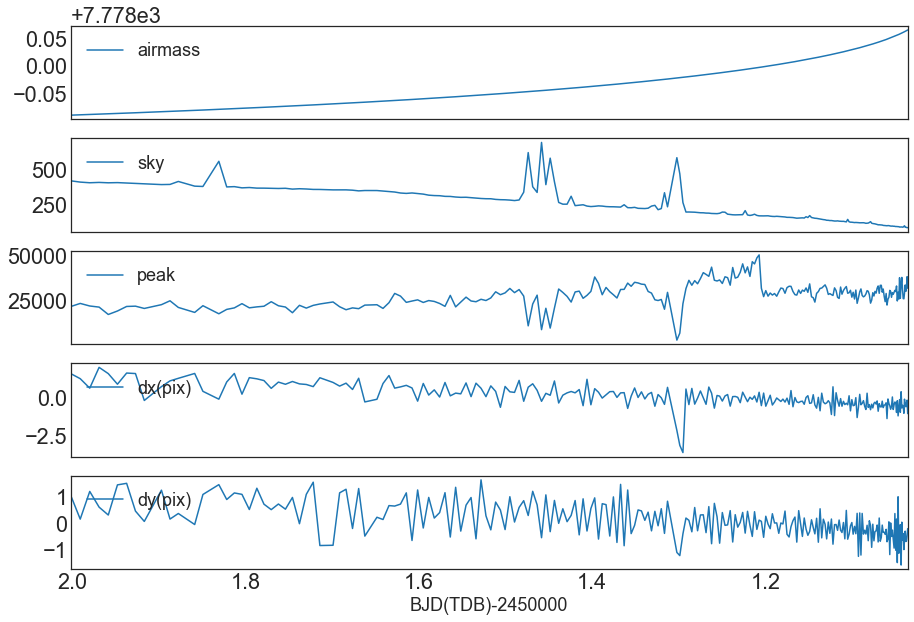

In [33]:
fig,ax=pl.subplots(5,1,figsize=(15,10), sharex=True)

aux_cols='airmass,sky,peak,dx(pix),dy(pix)'.split(',')

for n,c in enumerate(aux_cols):
    df_z[c].plot(ax=ax[n],label=c)
    ax[n].legend(loc='upper left')
    #ax[n].set_xticks([])
    #ax[n].set_xlabel('')
#fig.tight_layout()

## combined g-,r-,z-band (working light curve)

In [34]:
len(df_g['flux(r=28.0)']), len(df_r['flux(r=28.0)']), len(df_z['flux(r=28.0)'])

(210, 548, 244)

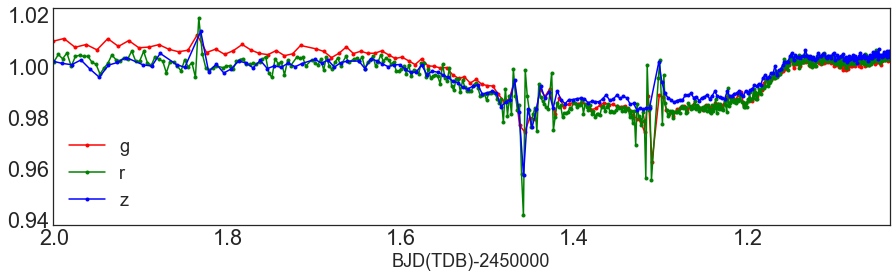

In [38]:
fig,ax = pl.subplots(1,1,figsize=(15,4))

df_g['flux(r=28.0)'].plot(ax=ax, marker='.', label='g', color='r')
df_r['flux(r=28.0)'].plot(ax=ax, marker='.', label='r', color='g')
df_z['flux(r=28.0)'].plot(ax=ax, marker='.', label='z', color='b')
pl.legend()

## Save

In [43]:
df_g.to_csv('g-band.csv')
df_r.to_csv('r-band.csv')
df_z.to_csv('z-band.csv')